# TP de méthodes variationnelles

In [1]:
import os
import platform
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import io as skio
import IPython

In [2]:
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES:
colaboratory = False  # mettre True si vous utilisez google colab
notebook = True  # mettre True si vous utilisez un notebook local

assert not (
    colaboratory and notebook
), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if (
    notebook
):  # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook

    output_notebook()

Loading BokehJS ...

In [3]:
def viewimage(im, normalise=True, MINI=0.0, MAXI=255.0, titre=""):
    """Cette fonction fait afficher l'image EN NIVEAUX DE GRIS
    dans gimp. Si un gimp est deja ouvert il est utilise.
    Par defaut normalise=True. Et dans ce cas l'image est normalisee
    entre 0 et 255 avant d'être sauvegardee.
    Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
    """
    imt = np.float32(im.copy())
    if platform.system() == "Darwin":  # on est sous mac
        prephrase = "open -a /Applications/GIMP.app "
        endphrase = " &"
    elif platform.system() == "Linux":  # SINON ON SUPPOSE LINUX
        prephrase = "gimp -a "
        endphrase = " &"
    elif platform.system() == "Windows":
        prephrase = '"C:/Program Files/GIMP 2/bin/gimp-2.10.exe" '
        endphrase = ""
    else:
        print("Systeme non pris en charge par l'affichage GIMP")
        return "erreur d afficahge"

    if normalise:
        m = imt.min()
        imt = imt - m
        M = imt.max()
        if M > 0:
            imt = imt / M
    else:
        imt = (imt - MINI) / (MAXI - MINI)
        imt[imt < 0] = 0
        imt[imt > 1] = 1

    if titre != "":
        titre = "_" + titre + "_"

    nomfichier = tempfile.mktemp("TPIMA" + titre + ".png")
    commande = prephrase + nomfichier + endphrase
    skio.imsave(nomfichier, imt)
    os.system(commande)


# si on est dans un notebook (y compris dans colab), on utilise bokeh pour visualiser
usebokeh = colaboratory or notebook
if usebokeh:

    def normalise_image_pour_bokeh(X, normalise, MINI, MAXI):
        imt = np.copy(X.copy())
        if normalise:
            m = imt.min()
            imt = imt - m
            M = imt.max()
            if M > 0:
                imt = imt / M

        else:
            imt = (imt - MINI) / (MAXI - MINI)
            imt[imt < 0] = 0
            imt[imt > 1] = 1
        imt *= 255

        sortie = np.empty((*imt.shape, 4), dtype=np.uint8)
        for k in range(3):
            sortie[:, :, k] = imt
        sortie[:, :, 3] = 255
        return sortie

    def viewimage(im, normalise=True, MINI=0.0, MAXI=255.0, titre=""):
        img = normalise_image_pour_bokeh(
            np.flipud(im), normalise, MINI, MAXI
        )  # np.flipud(np.fliplr(im)))
        p = figure(
            tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], title=titre
        )
        p.x_range.range_padding = p.y_range.range_padding = 0

        # must give a vector of images
        p.image_rgba(image=[img], x=0, y=0, dw=im.shape[1], dh=im.shape[0])
        showbokeh(p)

In [4]:
def viewimage(im, normalize=True, titre="", displayfilename=False):
    imin = im.copy().astype(np.float32)
    if normalize:
        imin -= imin.min()
    if imin.max() > 0:
        imin /= imin.max()
    else:
        imin = imin.clip(0, 255) / 255

    imin = (imin * 255).astype(np.uint8)
    filename = tempfile.mktemp(titre + ".png")
    if displayfilename:
        print(filename)
    plt.imsave(filename, imin, cmap="gray")
    IPython.display.display(IPython.display.Image(filename))

In [5]:
def appfiltre(u, K):
    """applique un filtre lineaire (en utilisant une multiplication en Fourier)"""

    fft2 = np.fft.fft2
    ifft2 = np.fft.ifft2
    out = np.real(ifft2(fft2(u) * fft2(K)))
    return out


def degrade_image(im, br):
    """degrade une image en lui ajoutant du bruit"""
    out = im + br * np.random.randn(*im.shape)
    return out


def grady(I):
    """Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
    i.e. l'image est symétrisée et le gradient en bas est nul"""

    (m, n) = I.shape
    M = np.zeros((m, n))
    M[:-1, :] = -I[:-1, :] + I[1:, :]
    M[-1, :] = np.zeros((n,))
    return M


def gradx(I):
    """Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
    i.e. l'image est symétrisée et le gradient a droite est nul"""

    (m, n) = I.shape
    M = np.zeros((m, n))
    M[:, :-1] = -I[:, :-1] + I[:, 1:]
    M[:, -1] = np.zeros((m,))
    return M


def div(px, py):
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m, n) = px.shape
    assert px.shape == py.shape, " px et py n'ont pas la meme taille dans div"
    Mx = np.zeros((m, n))
    My = np.zeros((m, n))

    My[1:-1, :] = py[1:-1, :] - py[:-2, :]
    My[0, :] = py[0, :]
    My[-1, :] = -py[-2, :]

    Mx[:, 1:-1] = px[:, 1:-1] - px[:, :-2]
    Mx[:, 0] = px[:, 0]
    Mx[:, -1] = -px[:, -2]
    return Mx + My


def gradient_TV(v, u, lamb):
    """calcule le gradient de la fonctionnelle E2 du TP"""
    # on n'utilise pas gradx et grady car pour minimiser
    # la fonctionnelle E2 par descente de gradient nous avons choisi
    # de prendre les memes conditions au bords que pour la resolution quadratique
    (sy, sx) = v.shape
    Kx = np.zeros((sy, sx))
    Ky = np.zeros((sy, sx))
    Kx[0, 0] = 1
    Kx[0, 1] = -1
    Ky[0, 0] = 1
    Ky[1, 0] = -1
    Kxback = np.zeros((sy, sx))
    Kyback = np.zeros((sy, sx))
    Kxback[0, 0] = -1
    Kxback[0, -1] = 1
    Kyback[0, 0] = -1
    Kyback[-1, 0] = 1

    Dx = appfiltre(u, Kx)
    Dy = appfiltre(u, Ky)
    ng = (Dx**2 + Dy**2) ** 0.5 + 1e-5
    div = appfiltre(Dx / ng, Kxback) + appfiltre(Dy / ng, Kyback)
    return 2 * (u - v) - lamb * div


def gradient_TV_nonperiodique(v, u, lamb):
    """calcule le gradient de la fonctionnelle E2 du TP"""
    gx = gradx(u)
    gy = grady(u)
    ng = ((gx**2) + (gy**2)) ** 0.5 + 1e-5
    dive = div(gx / ng, gy / ng)
    return 2 * (u - v) - lamb * dive


def resoud_quad_fourier(K, V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
    ou les K_i et les Vi sont des filtres et des images respectivement"""

    n = len(K)
    assert len(K) == len(V), "probleme de nombre de composantes dans resoud_quad"
    (sy, sx) = K[0].shape
    numer = np.vectorize(complex)(np.zeros((sy, sx)))
    denom = np.vectorize(complex)(np.zeros((sy, sx)))
    fft2 = np.fft.fft2
    ifft2 = np.fft.ifft2
    for k in range(n):
        fV = fft2(V[k])
        fK = fft2(K[k])
        # print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer += np.conj(fK) * fV
        denom += abs(fK) ** 2
    return np.real(ifft2(numer / denom))


def minimisation_quadratique(v, lamb):
    """minimise la fonctionnelle E1 du TP"""
    (sy, sx) = v.shape
    Kx = np.zeros((sy, sx))
    Ky = np.zeros((sy, sx))
    Kx[0, 0] = 1
    Kx[0, 1] = -1
    Ky[0, 0] = 1
    Ky[1, 0] = -1
    delta = np.zeros((sy, sx))
    delta[0, 0] = 1.0
    s = lamb**0.5
    K = (s * Kx, s * Ky, delta)
    V = (np.zeros((sy, sx)), np.zeros((sy, sx)), v)
    return resoud_quad_fourier(K, V)


def norme_VT(I):
    """renvoie la norme de variation totale de I"""
    (sy, sx) = I.shape
    Kx = np.zeros((sy, sx))
    Ky = np.zeros((sy, sx))
    Kx[0, 0] = 1
    Kx[0, 1] = -1
    Ky[0, 0] = 1
    Ky[1, 0] = -1
    Dx = appfiltre(I, Kx)
    Dy = appfiltre(I, Ky)
    ng = (Dx**2 + Dy**2) ** 0.5
    return ng.sum()


def norme_VT_nonperiodique(u):
    gx = gradx(u)
    gy = grady(u)
    ng = ((gx**2) + (gy**2)) ** 0.5
    return ng.sum()


def norm2(x):
    return ((x**2).sum()) ** 0.5


def E2_nonperiodique(u, v, lamb):  # renvoie l'énergie E2
    return lamb * norme_VT_nonperiodique(u) + norm2(u - v) ** 2


def minimise_TV_gradient(v, lamb, pas, nbpas):
    """minimise E2 par descente de gradient a pas constant"""
    u = np.zeros(v.shape)
    Energ = np.zeros(nbpas)
    for k in range(nbpas):
        # print(k)
        Energ[k] = E2_nonperiodique(u, v, lamb)
        u = u - pas * gradient_TV_nonperiodique(v, u, lamb)
    return (u, Energ)


def projection(I, a, itmax):
    """calcule la projection de I sur G_a
    G_a est le sous-gradient de TV en zero
    Comme vu dans le poly cette projection permet de resoudre le probleme
    de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m, n) = I.shape
    t = 0.1249
    px = np.zeros((m, n))
    py = np.zeros((m, n))
    un = np.ones((m, n))

    for it in range(itmax):
        N = div(px, py) - I / a
        Gx = gradx(N)
        Gy = grady(N)
        G = (Gx**2 + Gy**2) ** 0.5
        pxnew = (px + t * Gx) / (un + t * G)
        pynew = (py + t * Gy) / (un + t * G)
        px = pxnew
        py = pynew
    # la projection est la divergence du champ px,py
    P = a * div(px, py)
    return P


def vartotale_Chambolle(v, lamb, itmax=100):
    """Trouve une image qui minimise lamb*TV(I)+||I-v||^2
    en utilisant la projection dur G_a"""
    (m, n) = v.shape
    P = projection(v, lamb / 2, itmax)
    return v - P


def imread(fichier):
    return np.float32(skio.imread(fichier))

In [6]:
im = imread("lena.tif")
imb = degrade_image(im, 25)

## TP

In [7]:
def dichotomic_search_zero(
    function, left_bound, right_bound, tolerance=1e-6, max_iterations=1000
):
    for iteration in range(max_iterations):
        mid_point = (left_bound + right_bound) / 2

        # Evaluate the function at the mid-point and its neighbors
        f_mid = function(mid_point)
        f_left = function(left_bound)
        f_right = function(right_bound)

        # Check if the minimum is on the left or right side of the interval
        if f_left * f_mid <= 0:
            right_bound = mid_point
        else:
            left_bound = mid_point

        # Check for convergence
        if abs(f_right - f_left) < tolerance:
            break

    # Return the minimum value and the argument at which it occurs
    min_value = function((left_bound + right_bound) / 2)
    min_argument = (left_bound + right_bound) / 2
    return min_value, min_argument

Best lambda: 3.187


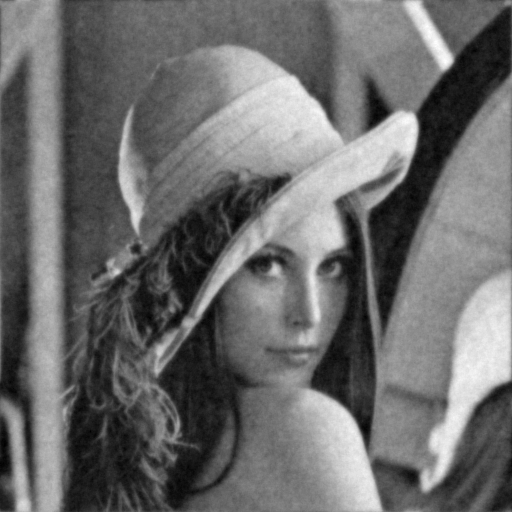

In [8]:
im = imread("lena.tif")
imb = degrade_image(im, 5**2)

t = norm2(im - imb) ** 2
function = lambda lamb: norm2(minimisation_quadratique(imb, lamb) - imb) ** 2 - t

min_error, min_lambda = dichotomic_search_zero(
    function=function,
    left_bound=1,
    right_bound=1e3,
    tolerance=1e-6,
    max_iterations=1000,
)

print(f"Best lambda: {min_lambda:.3f}")
viewimage(minimisation_quadratique(imb, min_lambda))

In [9]:
def dichotomic_minimization(
    function, left_bound, right_bound, tolerance=1e-6, max_iterations=1000
):
    x = []
    y = []
    for iteration in range(max_iterations):
        mid_point = (left_bound + right_bound) / 2

        # Evaluate the function at the mid-point and its neighbors
        f_mid = function(mid_point)
        f_left = function(left_bound)
        f_right = function(right_bound)
        if f_right <= f_mid:
            left_bound = mid_point
        else:
            right_bound = mid_point

        # Check for convergence
        if abs(f_right - f_left) < tolerance:
            break

    # Return the minimum value and the argument at which it occurs
    min_value = function((left_bound + right_bound) / 2)
    min_argument = (left_bound + right_bound) / 2
    return min_value, min_argument

Best lambda: 1.183


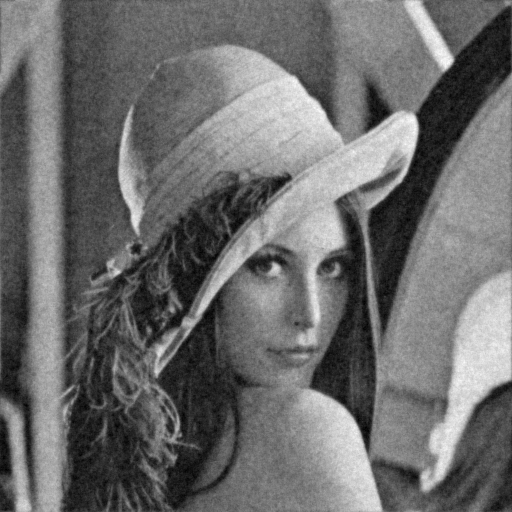

In [10]:
im = imread("lena.tif")
imb = degrade_image(im, 5**2)

function = lambda lamb: norm2(minimisation_quadratique(imb, lamb) - im) ** 2

min_error, min_lambda = dichotomic_minimization(
    function=function,
    left_bound=1,
    right_bound=1e3,
    tolerance=1e-6,
    max_iterations=1000,
)

print(f"Best lambda: {min_lambda:.3f}")
viewimage(minimisation_quadratique(imb, min_lambda))

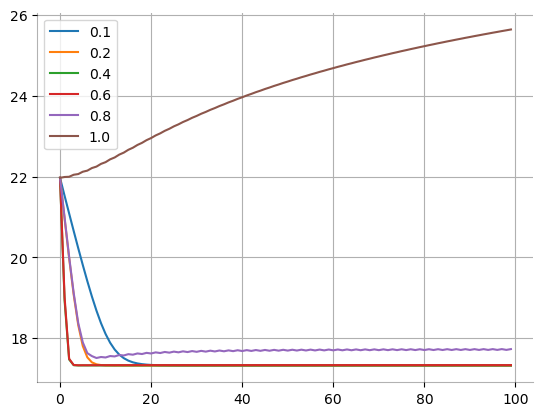

In [11]:
im = imread("lena.tif")
imb = degrade_image(im, 5**2)

u, energ01 = minimise_TV_gradient(imb, 3, 0.1, 100)
u, energ02 = minimise_TV_gradient(imb, 3, 0.2, 100)
u, energ04 = minimise_TV_gradient(imb, 3, 0.4, 100)
u, energ06 = minimise_TV_gradient(imb, 3, 0.6, 100)
u, energ08 = minimise_TV_gradient(imb, 3, 0.8, 100)
u, energ10 = minimise_TV_gradient(imb, 3, 1.0, 100)

plt.plot(np.log(energ01[:100]), label="0.1")
plt.plot(np.log(energ02[:100]), label="0.2")
plt.plot(np.log(energ04[:100]), label="0.4")
plt.plot(np.log(energ06[:100]), label="0.6")
plt.plot(np.log(energ08[:100]), label="0.8")
plt.plot(np.log(energ10[:100]), label="1.0")

plt.gca().spines["top"].set_alpha(0.0)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)
plt.gca().spines["left"].set_alpha(0.3)

plt.grid()
plt.legend()
plt.show()

In [12]:
lamb = 3
u_grad, energ_quad = minimise_TV_gradient(imb, lamb, 0.6, 100)
u_chamb = vartotale_Chambolle(imb, lamb, 100)

function = lambda u: norm2(u - im) ** 2
print(function(u_grad))
print(function(u_chamb))

133633477.1786435
133492290.51283129


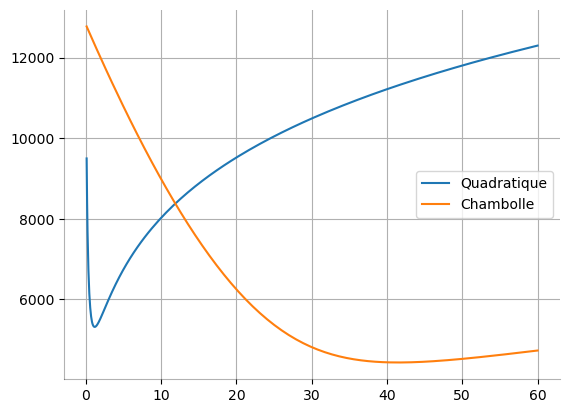

In [13]:
im = imread("lena.tif")
imb = degrade_image(im, 5**2)

errvt = []
erreur = []
vk = np.concatenate((np.linspace(0.1, 3, 50), np.linspace(3, 60, 120)))

for k in vk:
    restq = minimisation_quadratique(imb, k)
    restva = vartotale_Chambolle(imb, k)
    erreur.append(norm2(im - restq))
    errvt.append(norm2(restva - im))

plt.plot(vk, erreur, label="Quadratique")
plt.plot(vk, errvt, label="Chambolle")

plt.gca().spines["top"].set_alpha(0.0)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)
plt.gca().spines["left"].set_alpha(0.3)

plt.grid()
plt.legend()
plt.show()

print(vk[np.argmin(erreur)])
print(vk[np.argmin(errvt)])
print(np.min(erreur)/np.min(errvt))